### Used dataset: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import  Counter, defaultdict
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import contractions
from transformers import BertForSequenceClassification, BertTokenizer

## 0. Data Understanding

In [2]:
raw_data = pd.read_csv('../Reviews.csv').drop(columns=['Id'])
raw_data.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
raw_data.shape

(568454, 9)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568428 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 39.0+ MB


In [5]:
raw_data.isna().sum()

ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
raw_data['Score'].unique()

array([5, 1, 4, 2, 3])

## 1. Data Cleaning and Text Processing 

#### Rename columns to make their names standardized

In [7]:
standardized_col_names = [col.lower() for col in list(raw_data.columns)]
raw_data.columns = standardized_col_names
cols_to_rename = {'productid': 'product_id',
                 'userid': 'user_id', 
                 'profilename': 'profile_name',
                 'helpfulnessnumerator': 'helpfulness_numerator',
                 'helpfulnessdenominator': 'helpfulness_denominator'}
raw_data.rename(columns=cols_to_rename, inplace=True)
raw_data.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Lowercase all text in 'summary' and 'text' columns

In [8]:
lowercased_data = raw_data.copy(deep=True)
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']] \
.map(lambda x: x.lower() if isinstance(x, str) else x)

# view changes
lowercased_data['text'][420]

'i was not expecting to like these cookies as much as i do. i like chocolate chip cookies well enough, but i really prefer a soft cookie to crisp ones. i have to say these famous amos cookies have pertty much turned me around. the cookies are rich and have that depth of flavor that comes from quality ingredients. the chips are real chocolate and melt redilly in your mouth creating a moist experience while chewing. these are truly great cookies.'

#### Remove punctuation from 'summary' and 'text' 

In [9]:
non_alphb_pattern = r'[^\w\s]'
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']] \
.replace(non_alphb_pattern, '', regex=True)

In [10]:
# view changes
lowercased_data['text'][3549]

'somehow i feel healtier eating these things instead of peanuts i dont know why either also unlike peanuts i can limit my intake to a handful and not the whole bag'

#### Contractions handling

In [11]:
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']].map(
    lambda x: ' '.join(contractions.fix(word) if isinstance(word, str) else str(word) for word in str(x).split())
)

In [12]:
#view changes
lowercased_data['text'][3549]

'somehow i feel healtier eating these things instead of peanuts i do not know why either also unlike peanuts i can limit my intake to a handful and not the whole bag'

#### Dropping rows with *None* values in 'summary' column
As original dataset contains a large number of samples, we may assume that removing 27 rows with *None* values in *'summary'* column will not affect the model's generalization ability 

In [13]:
clean_data = lowercased_data[lowercased_data['summary'].notnull()]
clean_data.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good quality dog food,i have bought several of the vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,delight says it all,this is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,cough medicine,if you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at a great price there was a wide ...


## 2. Exploratory Data Analysis

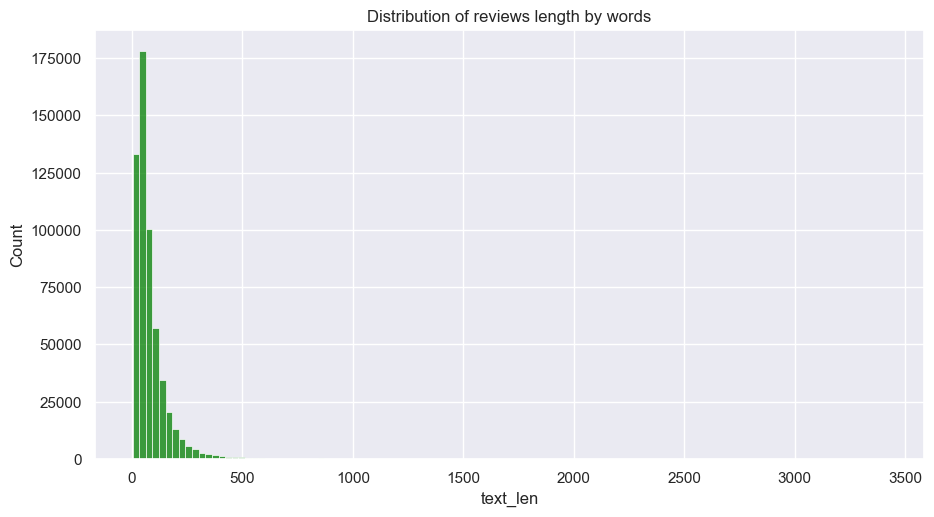

In [14]:
clean_data['text_len'] = clean_data['text'].apply(lambda x: len(str(x).split()))
sns.set(rc={'figure.figsize':(10.7, 5.57)})
sns.histplot(data=clean_data, 
             x='text_len', 
             binwidth=30, 
             color='green') \
.set(title='Distribution of reviews length by words')
clean_data.drop(columns=['text_len'])
plt.show()

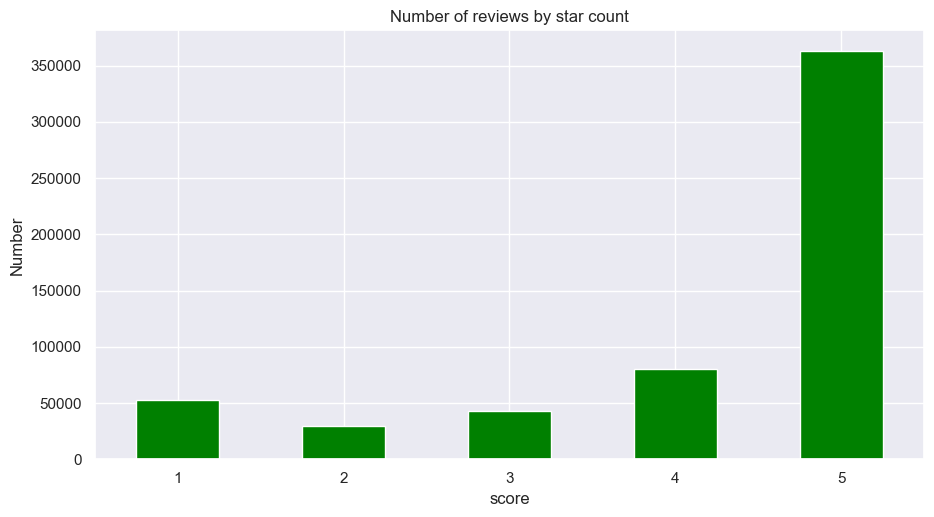

In [15]:
clean_data['score'].value_counts().sort_index() \
.plot(kind='bar', color='green')
plt.xticks(rotation=0)
plt.ylabel('Number')
plt.title('Number of reviews by star count')
plt.show()

#### Helper function

In [16]:
def generate_word_cloud(*score_values):
    
    """
    Generates and shows word cloud for text from Summary column using rows based on 
    specific given values for Score column.

    Params:
        *score_values(list of ints): Values of the 'Score' column used to filter rows.
    
    Returns:
        None
    
    Raises:
        ValueError: If no parameters given, list is empty or values from list are not from range [0; 5].
    """
    if score_values and all(0 <= score <= 5 for score in score_values):
        words = clean_data.loc[clean_data['score'].isin(score_values), 'summary'].str.cat(sep=' ')
        wordcloud = WordCloud(background_color='white').generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        raise ValueError('Non-empty integer list in range [0; 5] must be provided')

#### Possible positive reviews 

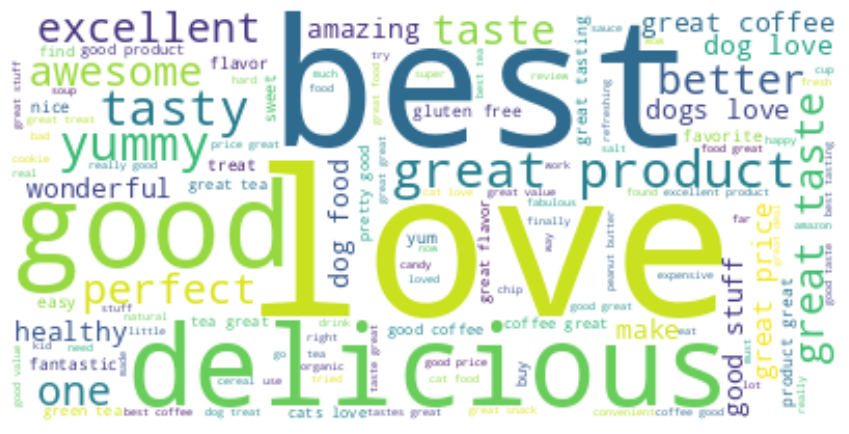

In [17]:
generate_word_cloud(*[4, 5])

#### Possible neutral reviews

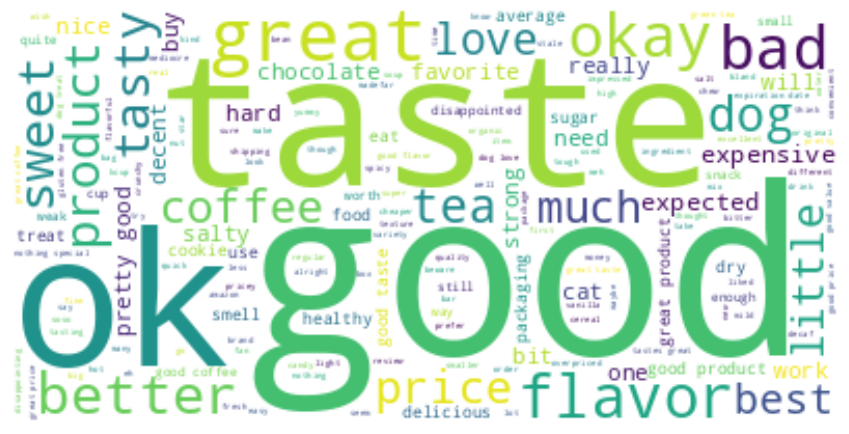

In [18]:
generate_word_cloud(*[3])

#### Possible negative reviews

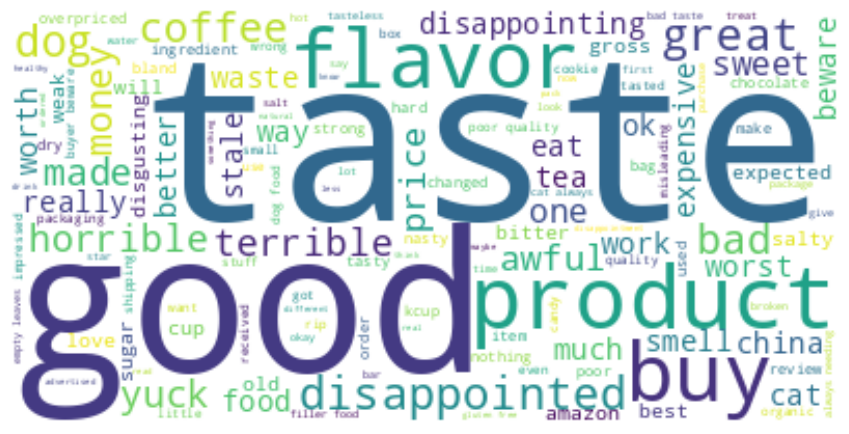

In [19]:
generate_word_cloud(*[1, 2])

#### Define stop words

In [20]:
stop_words = set(stopwords.words('english'))

#### Helper function 

In [56]:
def find_and_plot_top_words(df: pd.DataFrame, col_name: str, n: int, for_stopwords=False):
    """
    Creates a Counter object from dictionary with words and their frequencies within a given column with text data.
    Builds and shows a barplot with specified number of top words according to their frequencies. 

    Params:
        Args:
            df(pd.DataFrame): pre-defined DataFrame object.
            col_name(str): name of the text data column we are interested in. 
            n(int): number of top-frequent words to include in the plot.
        Kwargs:
            for_stopwords(bool): to determine whether we are interested in actual words or words from stopwords set (default: False).

    Returns:
        None

    Raises:
        ValueError: when the column with a specified name is not found in a given dataframe; when n <= 0.
    """
    if col_name in df.columns:
        if n > 0:
            current_corpus = [word for sublist in df[col_name].str.split().tolist() for word in sublist]
            counter = Counter(current_corpus)
            if not for_stopwords:
                filtered_freq_counter = Counter({word: freq for word, freq in counter.items() if word not in stop_words})
                top = filtered_freq_counter.most_common(n)
                top_words, top_freqs = zip(*top)
        
                sns.barplot(x=top_freqs, y=top_words, hue=top_words, legend=False)
                plt.show()
            else:
                stop_words_freq_counter = Counter({word: freq for word, freq in counter.items() if word in stop_words})
                top = stop_words_freq_counter.most_common(n)
                stop_words_top, stop_words_top_freqs = zip(*top)
            
                sns.barplot(x=stop_words_top, y=stop_words_top_freqs)
                plt.show()
        else:
            raise ValueError(f'n must be a positive integer')
    else:
        raise ValueError(f'Given column is not found in this DataFrame')

#### Plot top-20 most frequent words over *'text'* column

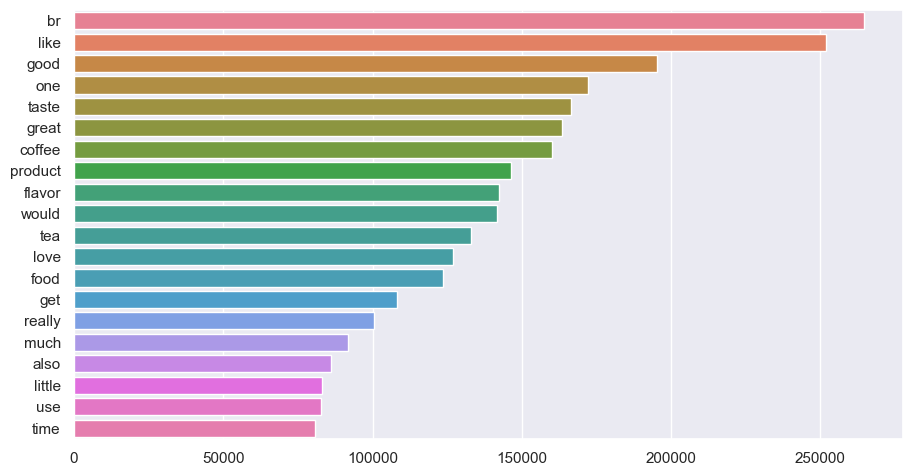

In [49]:
find_and_plot_top_words(clean_data, 'text', 20, False)

#### Plot top-20 most frequent words over 'summary' columns

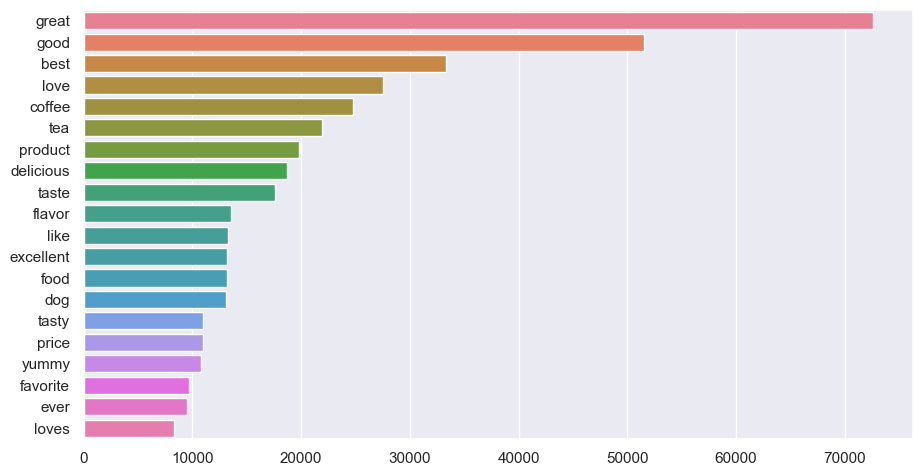

In [50]:
find_and_plot_top_words(clean_data, 'summary', 20, False)

#### Plot top-10 most frequent stopwords in *'text'* column

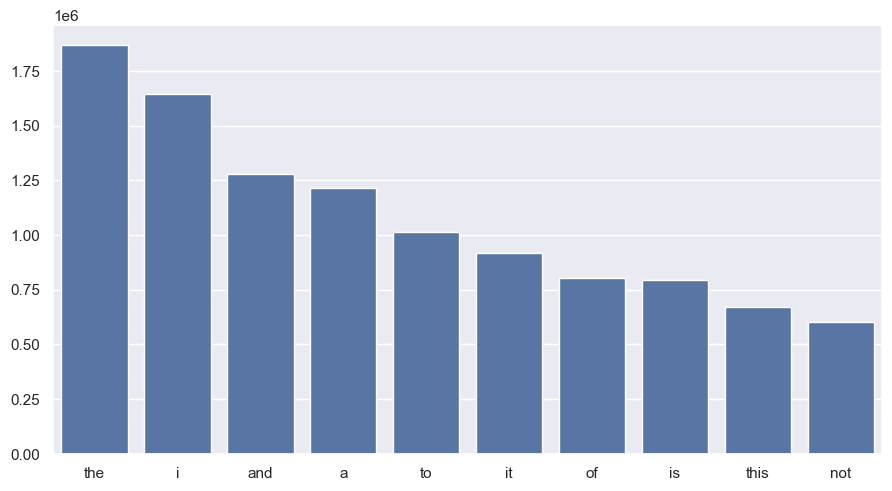

In [55]:
find_and_plot_top_words(clean_data, 'text', 10, True)

#### Plot top-10 most frequent stopwords in *'summary'* column

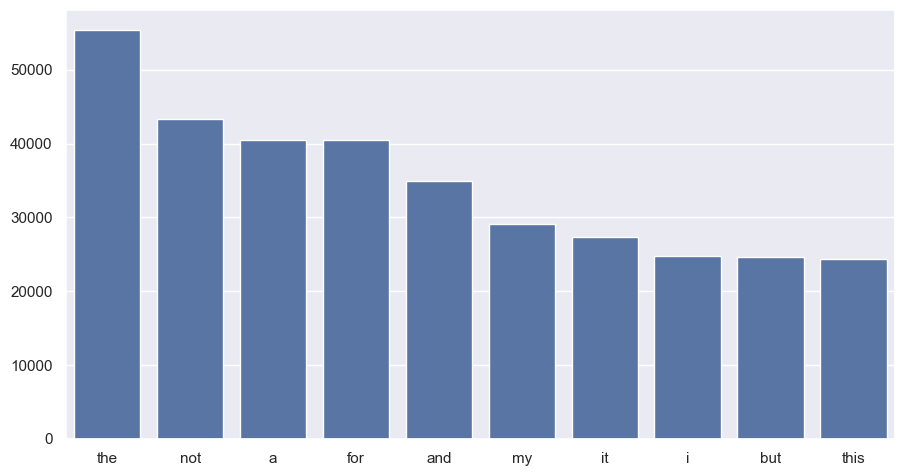

In [54]:
find_and_plot_top_words(clean_data, 'summary', 10, True)

## 3. Sentiment Analysis